<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Small playground using Agrimetrics API

J Gomez-Dans

The Agrimetrics API allows you to do some queries of a database using (among other things) geographical units. This notebook shows how to select some data using a map, and then

* Recover the list of fields from agrimetrics (this doesn't seem to be available to trial users),
* Recover some parameters (I decided to retrieve the soil texture, as this is often a requirement to calculate the water balance in the soil, and hence evapotranspiration, and hence water stress)
* Retrieve some LAI derived from Sentinel 2 for the selected polygon.

The code then goes on to do some plots.

Note that there are quite a few limitations on what you are allowed to do with the API. 

In [1]:
%load_ext autoreload
%autoreload 2
import datetime as dt
import json
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gdal
gdal.UseExceptions()   
import ipywidgets

from playground import s2_db
from playground.query_api import get_wkt_polygon, calc_centroid
from playground.query_api import get_wkt_polygon, calc_centroid
from playground.query_api import get_all_field_boundaries
from playground.query_api import find_field_texture

##################################
# Set up Agrimetrics API key
##################################
api_key = os.environ.get("AGRIMETRICS_KEY")

if api_key is None:
    try:
        with open(os.path.expanduser(
            "~/.config/agrimetrics_key.txt"), 'r') as fp:
            api_key = fp.read().strip("\n")
    except:
        print("No API key found. Set it here")
        api_key=""



##################################
# Set up S2 database
##################################


s2_db = s2_db.S2LAIdb()



/home/ucfajlg/.local/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [7]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, GeoJSON, TileLayer

background = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)
m = Map(layers=(background,), center=(51.77, 0.088), zoom=8
       )
draw_control = DrawControl()



feature_collection = {
    'type': 'FeatureCollection',
    'features': []
}

def handle_draw(self, action, geo_json):
    """Do something with the GeoJSON when it's drawn on the map"""
    feature_collection['features'].append(geo_json)

draw_control.on_draw(handle_draw)
m.add_layer(GeoJSON(data=json.load(open("./s2_db.geojson", "r")),
                   style = {'color': 'green', 'opacity':1, 
                            'weight':1.9, 'dashArray':'9', 'fillOpacity':0.1}))
m.add_layer(GeoJSON(data=json.load(open("./restricted_area.geojson", "r")),
                   style = {'color': 'red', 'opacity':1, 
                            'weight':1.9, 'dashArray':'9', 'fillOpacity':0.1}))



m.add_control(draw_control)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [8]:
poly = json.dumps(feature_collection)

# You can't seem to get hold of the boundaries on the trial account. Groan...
# So the next bit is actually commented out.
##ff = get_all_field_boundaries(get_wkt_polygon(feature_collection), api_key)

gg = find_field_texture(*calc_centroid(feature_collection), api_key)

data = s2_db.get_time_series(poly)
str0 = f"Field code: => {gg[0]} <= "
str1 = " ".join( [f"{k.capitalize()} % {v} "
                  for k, v in gg[1].items()])
print(str0 + str1)

Field code: => xwek3CEgEdEPaLp-_cr3pw <= Clay % 23.69  Sand % 36.41  Silt % 39.9 


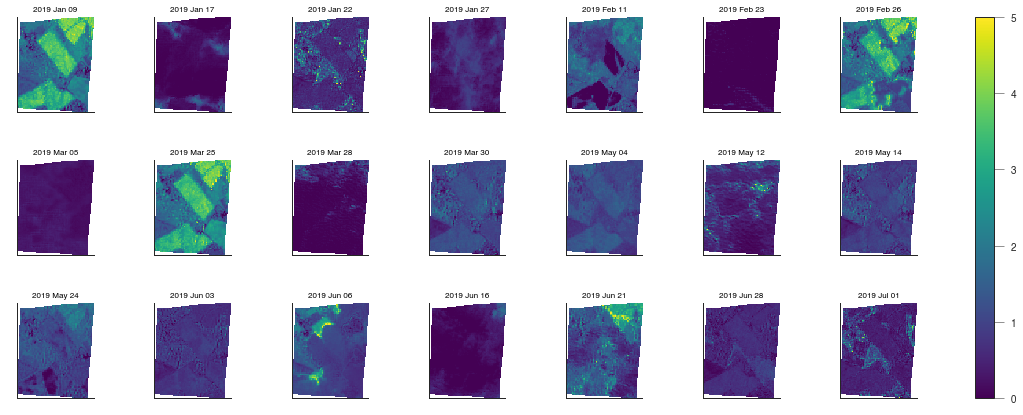

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=7, figsize=(21, 7), sharex=True, sharey=True, squeeze=True)
axs = axs.flatten()
for ii,(k, v) in enumerate(data.items()):
    im = axs[ii].imshow(v, vmin=0, vmax=5)
    axs[ii].set_title(k.strftime("%Y %b %d"), fontsize=8)
    axs[ii].set_xticks([])
    axs[ii].set_yticks([])
    
fig.colorbar(im, ax=axs.ravel().tolist())
